In [1]:
#====================================
# Author: Waleed M. Gondal
# Date: 22, December, 2016
#====================================
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from config_vgg import VGG16
from utils import augment, make_batches, count_images
import os
import matplotlib.pyplot as plt
import time
from IPython import display
import csv

#================================================
# Setting Hyper-Parameters 
#================================================
PRETRAINED_MODEL_PATH = None
N_EPOCHS = 200
INIT_LEARNING_RATE = 0.001
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224
IMAGE_WIDTH   = 224
NUM_CHANNELS  = 3
BATCH_SIZE = 50
N_LABELS = 2
DROPOUT = 0.50  
LOGS_PATH = './tensorflow_logs/'
WEIGHT_PATH = 'vgg16_weights.npz'
TRAINSET_PATH = 'train.csv'
VALSET_PATH ='val.csv'
ckpt_dir = "./ckpt_dir_config1"

# Make Batches from csv files
Make batches of images and their respective labels using standard tensorflow input pipeline

In [2]:
train_image_batch, train_label_batch = make_batches(TRAINSET_PATH, N_EPOCHS, IMAGE_HEIGHT,
                                                    IMAGE_WIDTH, BATCH_SIZE, shuffle=False, training = True)
val_image_batch, val_label_batch = make_batches(VALSET_PATH, 1, IMAGE_HEIGHT,
                                                IMAGE_WIDTH, BATCH_SIZE, shuffle=False, training = False)

In [3]:
# Count the number of training and test examples
num_train = count_images(TRAINSET_PATH)
num_val = count_images(VALSET_PATH)
print ('Train_images: ', num_train)
print ('Validation_images: ', num_val)

('Train_images: ', 22501)
('Validation_images: ', 2499)


In [4]:
# Placeholders for tensorflow graph
learning_rate = tf.placeholder( tf.float32, [])
images_tf = tf.placeholder( tf.float32, [None, IMAGE_HEIGHT, IMAGE_WIDTH, 3], name="images")
labels_tf = tf.placeholder( tf.int64, [None], name='labels')  # the dimensions could be [None,N_CLASSES]

# Configure Network

In [5]:
network = VGG16(N_LABELS, WEIGHT_PATH)
output = network.inference(images_tf, is_training=True, dropout=DROPOUT)

conv1_1w (?, 224, 224, 64)
conv1_2w (?, 224, 224, 64)
conv2_1w (?, 112, 112, 128)
conv2_2w (?, 112, 112, 128)
conv3_1w (?, 56, 56, 256)
conv3_2w (?, 56, 56, 256)
conv3_3w (?, 56, 56, 256)
conv4_1w (?, 28, 28, 512)
conv4_2w (?, 28, 28, 512)
conv4_3w (?, 28, 28, 512)
conv5_1w (?, 14, 14, 512)
conv5_2w (?, 14, 14, 512)
conv5_3w (?, 14, 14, 512)
fc1 (?, 4096)
fc2 (?, 4096)


# Define Loss

In [6]:
with tf.name_scope('Loss'):
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels_tf, logits=output), name='loss_tf')
    loss_summary = tf.summary.scalar("loss", loss_tf)
    weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables() )
    weight_decay = tf.reduce_sum(tf.stack([tf.nn.l2_loss(x) for x in weights_only])) * WEIGHT_DECAY_RATE
    loss_tf += weight_decay

In [7]:
# Optimizer
train_op = tf.train.MomentumOptimizer(learning_rate, MOMENTUM).minimize(loss_tf)

In [8]:
# Training Accuracy per batch
correct_pred = tf.equal(tf.argmax(output, 1), labels_tf)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [9]:
# Saver Operation to save and restore all variables, first create directory
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)
saver = tf.train.Saver() 

# Training
Training would go on for 200 epochs. It keeps updating the plots of loss and accuracy curves as the training proceeds.

Note: Tensorflow summaries are intentionally being avoided as they consume precious memory on GPU servers, thats why we are plotting on runtime bases.

In [11]:
with tf.Session() as sess:
       
    sess.run(tf.global_variables_initializer())    
    sess.run(tf.local_variables_initializer())
    # Restoring pretrained weights
    #saver.restore(sess, PRETRAINED_MODEL_PATH)
    # Tensorflow Queing process, required to fill queues with data.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    # Define Lists for storing and plotting training statistics 
    loss_list, accuracy_list, validation_list, validation_loss = [], [], [], []
    plot_loss, plot_accuracy, plot_validation, plot_validation_loss = [], [], [], []
    store_epoch_time = []
    epoch_train_loss, epoch_train_accuracy = [], []
    train_loss_list, train_acc_list = [], []
        
    steps = 1
    batch_count = 1
    
    train_iter = int(num_train/BATCH_SIZE)     # Number of batches in training set
    val_iter = int(num_val/BATCH_SIZE)         # Number of batches in validation set
    print "Total number of training iterations", train_iter
    print "Total number of validation iterations", val_iter
    for epoch in range(2):          
        train_correct = 0
        train_data = 0    
        epoch_start_time = time.time()
        
        for i in range (train_iter):
            train_imbatch, train_labatch = sess.run([train_image_batch, train_label_batch])
            _, loss_val, off_acc= sess.run([train_op, loss_tf, accuracy], feed_dict={
                    learning_rate: INIT_LEARNING_RATE, images_tf: train_imbatch, labels_tf: train_labatch})
            
            # Appending Lists at each iteration for visualizing loss and accuracy curve 
            loss_list.append(loss_val)                              
            accuracy_list.append(off_acc)
            epoch_train_loss.append(loss_val)
            epoch_train_accuracy.append(off_acc)

            # Loss and Accuracy point added after 5 iterations, to make the curve more smooth
            if (steps) % 5 == 0:   
                plt.clf()
                display.clear_output(wait=True)
                
                # Appending Mean of last 5 iterations loss and accuracy values
                accuracy_5steps = np.mean(accuracy_list)
                loss_5steps = np.mean(loss_list)
                plot_accuracy.append(accuracy_5steps)
                plot_loss.append(loss_5steps)
          
                # Plotting
                fig = plt.figure(figsize=(8,8))
                ax1 = fig.add_subplot(221)
                ax1.plot(plot_loss,'r-')
                #ax1.legend(bbox_to_anchor=(1, 1.22))
                ax1.grid(True)
                ax1.set_title('Training Loss')
                #ax1.axis('off')
                
                ax2 = fig.add_subplot(222)
                ax2.plot(plot_accuracy,'k-')
                #ax2.legend(bbox_to_anchor=(1, 1.22))
                ax2.grid(True)
                ax2.set_title('Training Accuracy')
                #ax2.axis('off')
                
                ax3 = fig.add_subplot(223)
                ax3.plot(train_loss_list,'g-', label='Training Loss')
                ax3.plot(plot_validation_loss,'y-', label='Validation Loss')
                #ax3.legend(bbox_to_anchor=(0.5, 0.1))
                ax3.grid(True)
                ax3.set_title('Loss / epoch')
                #ax3.axis('off')
                
                ax4 = fig.add_subplot(224)
                ax4.plot(train_acc_list,'g-', label='Training ')
                ax4.plot(plot_validation,'y-', label='Validation ')
                ax4.legend(bbox_to_anchor=(1.9, 0.4))
                ax4.grid(True)
                ax4.set_title('Accuracy/epoch')
                #ax4.axis('off')

                plt.show()
                plt.pause(0.00001)
                #plt.draw()
                print "==============*TRAINING INFO*===================="
                print "Epoch", epoch+1, "Iteration", steps
                print "Processed", batch_count*BATCH_SIZE, '/', num_train
                print 'Accuracy in last 5 steps: ', accuracy_5steps
                print "Training Loss in last 5 steps:", loss_5steps
                loss_list = []
                accuracy_list = []
            steps += 1
            batch_count += 1
        
        train_loss_list.append(np.mean(epoch_train_loss))
        train_acc_list.append(np.mean(epoch_train_accuracy))
        epoch_train_loss, epoch_train_accuracy = [], []
        
        batch_count =1
        n_correct = 0
        n_data = 0
        epoch_time = (time.time() - epoch_start_time)/60.
        store_epoch_time.append(epoch_time)
        print 'Time Elapsed for Epoch:'+str(epoch+1)+' is '+str (epoch_time) +' minutes'
        
        #============================**VALIDATION**================================"
        
        for i in range (val_iter):            
            val_imbatch, val_labatch = sess.run([val_image_batch, val_label_batch])
            val_accuracy, val_loss = sess.run([accuracy,loss_tf], feed_dict={images_tf:val_imbatch, labels_tf: val_labatch})
            validation_list.append(val_accuracy)
            validation_loss.append(val_loss)
            
        validation_accuracy = np.mean(validation_list)
        plot_validation.append(validation_accuracy)
        plot_validation_loss.append(np.mean(validation_loss))
        validation_list, validation_loss = [], []

        # Learning rate update after each epoch
        INIT_LEARNING_RATE *= 0.96
        if ((epoch+1) % 1 == 0 or validation_accuracy >=0.90):            
            saver.save(sess, ckpt_dir + "/weight2.ckpt", global_step=epoch)

INFO:tensorflow:Error reported to Coordinator: <class 'tensorflow.python.framework.errors_impl.CancelledError'>, Enqueue operation was cancelled
	 [[Node: batch_1/fifo_queue_enqueue = QueueEnqueueV2[Tcomponents=[DT_FLOAT, DT_INT32], timeout_ms=-1, _device="/job:localhost/replica:0/task:0/cpu:0"](batch_1/fifo_queue, Squeeze_1, DecodeCSV_1:1)]]


KeyboardInterrupt: 

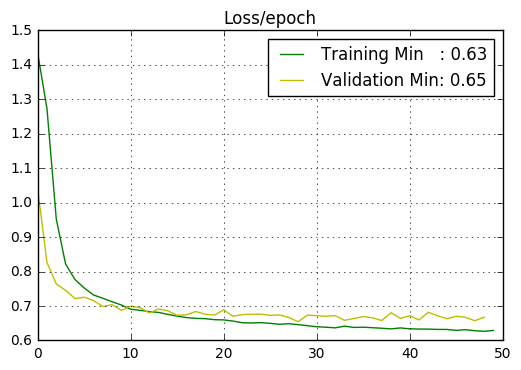

In [12]:
# LOSS Plot with initial loss value
train_loss_copy = train_loss_list
first_loss_pt =  plot_loss[0]
complete_loss = [first_loss_pt] + train_loss_copy
plt.plot(complete_loss, 'g-', label='Training Min   : %0.2f' % min(complete_loss))
plt.plot(plot_validation_loss,'y-', label='Validation Min: %0.2f' % min(plot_validation_loss))
plt.title('Loss/epoch')
plt.legend(bbox_to_anchor=(1., 1.))
plt.grid(True)

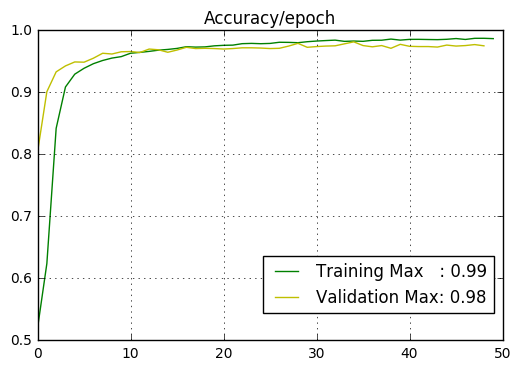

In [13]:
# Accuracy Plot with initial accuracy value
train_acc_copy = train_acc_list
first_acc_pt =  plot_accuracy[0]
complete_acc = [first_acc_pt] + train_acc_copy
plt.plot(complete_acc, 'g-', label='Training Max   : %0.2f' % max(complete_acc))
plt.plot(plot_validation,'y-', label='Validation Max: %0.2f' % max(plot_validation))
plt.title('Accuracy/epoch')
plt.legend(bbox_to_anchor=(1., 0.3))
plt.grid(True)

In [14]:
# For finding weight file with max value of Validation Accuracy 
print np.argmax(plot_validation)
print plot_validation #Thats validation accuracy

34
[0.80399996, 0.90120006, 0.9332, 0.94279999, 0.94919997, 0.94879997, 0.95519996, 0.96319997, 0.96199989, 0.96559995, 0.96599996, 0.96439993, 0.97000003, 0.96879995, 0.96480006, 0.96840006, 0.97280002, 0.97080004, 0.97120005, 0.97080004, 0.97000003, 0.97080004, 0.97200006, 0.97199994, 0.97160006, 0.97080004, 0.97120005, 0.97480005, 0.97920007, 0.9727999, 0.97399992, 0.97480005, 0.97520006, 0.97839999, 0.98160005, 0.97560006, 0.97360003, 0.9756, 0.97120005, 0.97760004, 0.97440004, 0.9740001, 0.97400004, 0.97320008, 0.97640002, 0.97480005, 0.9756, 0.97720003, 0.97520006]
